# FlatSat CSV Analysis
This notebook loads the latest CSV in `C:\Windows\System32\logs` and generates plots for every
logged subsystem. The CSV is a stateful snapshot log: each row is triggered by one `event_type`, and
other columns hold the last known values. For analysis, we filter by `event_type` so we only use
fresh values for each subsystem.



In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (10, 4),
    "axes.grid": True,
})

LOG_DIR = Path(r"C:\\Windows\\System32\\logs")

csv_files = sorted(LOG_DIR.glob("*.csv"), key=lambda p: p.stat().st_mtime)
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {LOG_DIR}")

latest_csv = csv_files[-1]
print(f"Using CSV: {latest_csv}")

df = pd.read_csv(latest_csv)

df["rx_utc_iso"] = pd.to_datetime(df["rx_utc_iso"], errors="coerce")

category_cols = {"event_type", "motor_mode", "motor_last_src", "motor_last_mode"}
for col in df.columns:
    if col == "rx_utc_iso" or col in category_cols:
        continue
    df[col] = pd.to_numeric(df[col], errors="coerce")

if df["event_sat_time_ms"].notna().any():
    t0 = df["event_sat_time_ms"].min()
    df["t_s"] = (df["event_sat_time_ms"] - t0) / 1000.0
else:
    t0 = df["rx_utc_iso"].min()
    df["t_s"] = (df["rx_utc_iso"] - t0).dt.total_seconds()


def event_df(event):
    return df[df["event_type"] == event].copy()


def require_cols(cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        print(f"Missing columns: {missing}")
        return False
    return True


def binned_stats(x, y, bin_s):
    data = pd.DataFrame({"t": x, "y": y}).dropna()
    if data.empty:
        return None
    data["bin"] = (data["t"] // bin_s).astype(int)
    stats = data.groupby("bin")["y"].agg(["mean", "std", "count"])
    stats["sem"] = stats["std"] / np.sqrt(stats["count"])
    stats["t_mid"] = (stats.index + 0.5) * bin_s
    return stats


def scatter_with_binned_mean(ax, x, y, bin_s, label=None, color=None, alpha=0.5, s=10):
    if color is None:
        color = ax._get_lines.get_next_color()
    ax.scatter(x, y, s=s, alpha=alpha, label=label, color=color)
    stats = binned_stats(x, y, bin_s)
    if stats is None or stats.empty:
        return
    ax.errorbar(
        stats["t_mid"],
        stats["mean"],
        yerr=stats["sem"],
        fmt="o-",
        color=color,
        ecolor=color,
        capsize=2,
        markersize=3,
        linewidth=1,
        alpha=0.8,
    )


print(f"Rows: {len(df)}")
print(f"Time span (s): {df['t_s'].min():.3f} to {df['t_s'].max():.3f}")
print(f"Event types: {sorted(df['event_type'].dropna().unique().tolist())}")

df.head()



Using CSV: C:\Windows\System32\logs\flatsat_session_20260128_111116.csv
Rows: 998
Time span (s): 0.000 to 473.935
Event types: ['CAM', 'MOT', 'MTQ', 'SPEC', 'SUN', 'TEL']


,rx_utc_iso,event_type,event_sat_time_ms,imu_yaw_deg,imu_roll_deg,imu_pitch_deg,accel_x_mps2,accel_y_mps2,accel_z_mps2,accel_pitch_deg,...,spec_line5_centroid_nm,spec_line5_fwhm_nm,spec_line5_snr,spec_line6_centroid_nm,spec_line6_fwhm_nm,spec_line6_snr,spec_line7_centroid_nm,spec_line7_fwhm_nm,spec_line7_snr,t_s
0,2026-01-28 11:11:17.146,TEL,103599,357.1875,7.6250,2.8125,1.24,-0.30,9.23,-7.647570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.514
1,2026-01-28 11:11:17.662,TEL,104097,-1690.8125,7.6875,2.6250,1.26,-0.30,9.21,-7.786071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.012
2,2026-01-28 11:11:19.100,TEL,104597,357.1875,7.6875,2.6250,1.26,-0.29,9.22,-7.778005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.512
3,2026-01-28 11:11:19.103,TEL,105097,357.1875,7.6875,2.6250,1.29,-0.30,9.23,-7.952070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.012
4,2026-01-28 11:11:19.145,TEL,105595,357.1875,7.6875,2.6250,1.26,-0.27,9.26,-7.745347,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.510


## Event inventory and downlink rate
These plots show how often each event type appears and the rate of downlinked events over time.



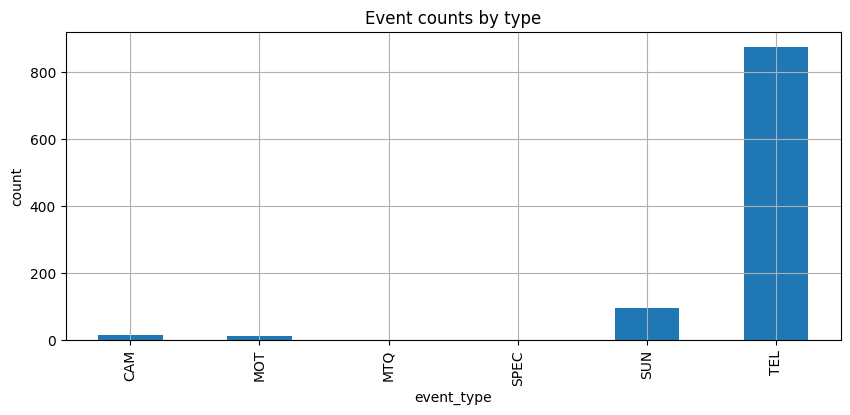

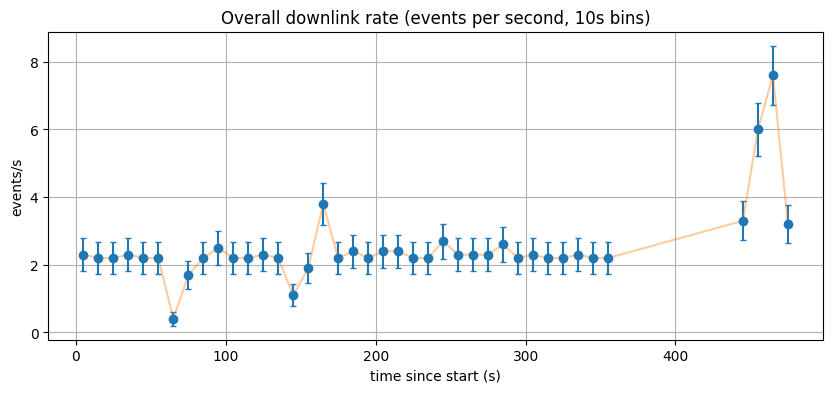

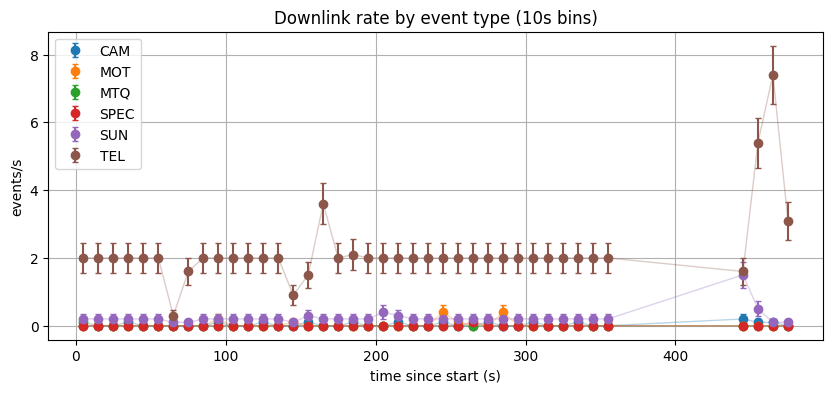

In [15]:
event_counts = df["event_type"].value_counts().sort_index()
ax = event_counts.plot(kind="bar", title="Event counts by type")
ax.set_xlabel("event_type")
ax.set_ylabel("count")
plt.show()

bin_s = 10
valid = df[df["t_s"].notna()].copy()
valid["bin"] = (valid["t_s"] // bin_s).astype(int)

counts_all = valid.groupby("bin").size()
t_mid = (counts_all.index + 0.5) * bin_s
rate_all = counts_all / bin_s
err_all = np.sqrt(counts_all) / bin_s

plt.figure()
plt.errorbar(t_mid, rate_all, yerr=err_all, fmt="o", capsize=2)
plt.plot(t_mid, rate_all, alpha=0.4)
plt.title(f"Overall downlink rate (events per second, {bin_s}s bins)")
plt.xlabel("time since start (s)")
plt.ylabel("events/s")
plt.show()

rate_by_counts = valid.groupby(["bin", "event_type"]).size().unstack(fill_value=0)
plt.figure()
colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
for i, col in enumerate(rate_by_counts.columns):
    counts = rate_by_counts[col]
    t_mid = (counts.index + 0.5) * bin_s
    rate = counts / bin_s
    err = np.sqrt(counts) / bin_s
    color = colors[i % len(colors)] if colors else None
    plt.errorbar(t_mid, rate, yerr=err, fmt="o", color=color, capsize=2, label=col)
    plt.plot(t_mid, rate, color=color, alpha=0.3, linewidth=1)
plt.title(f"Downlink rate by event type ({bin_s}s bins)")
plt.xlabel("time since start (s)")
plt.ylabel("events/s")
plt.legend()
plt.show()



## Telemetry (IMU and accelerometer)
Uses TEL rows only, so the plotted values represent fresh IMU and accelerometer samples.



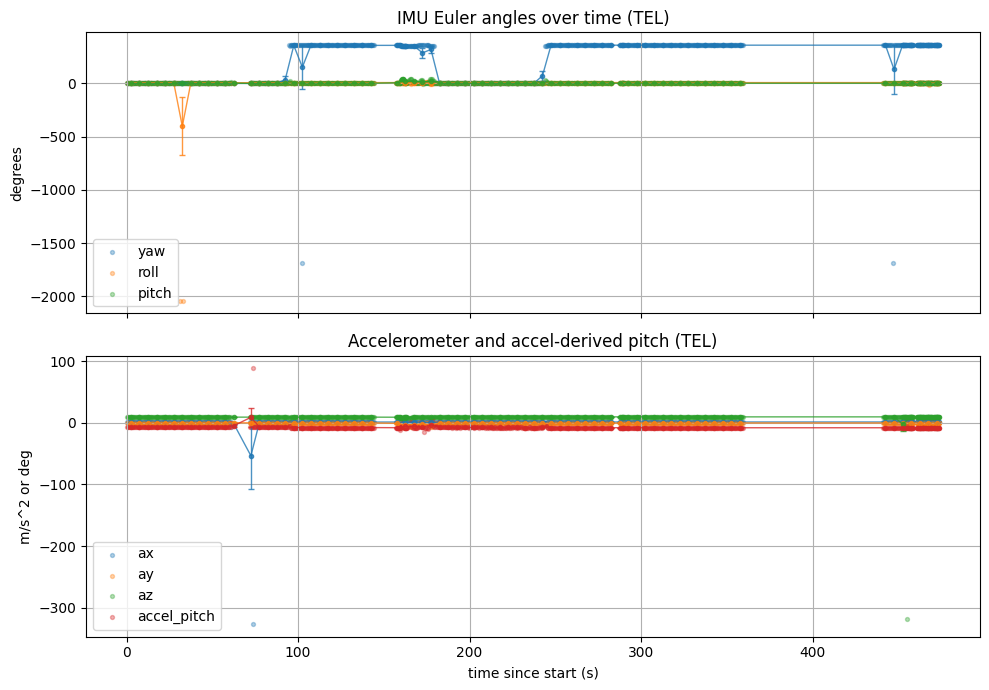

In [16]:
tel = event_df("TEL")
if tel.empty:
    print("No TEL rows found.")
else:
    bin_s = 5
    colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 7))

    imu_cols = [("yaw", "imu_yaw_deg"), ("roll", "imu_roll_deg"), ("pitch", "imu_pitch_deg")]
    for i, (label, col) in enumerate(imu_cols):
        color = colors[i % len(colors)] if colors else None
        scatter_with_binned_mean(axes[0], tel["t_s"], tel[col], bin_s, label=label, color=color, alpha=0.35, s=8)
    axes[0].set_title("IMU Euler angles over time (TEL)")
    axes[0].set_ylabel("degrees")
    axes[0].legend()

    acc_cols = [("ax", "accel_x_mps2"), ("ay", "accel_y_mps2"), ("az", "accel_z_mps2"), ("accel_pitch", "accel_pitch_deg")]
    for i, (label, col) in enumerate(acc_cols):
        color = colors[i % len(colors)] if colors else None
        scatter_with_binned_mean(axes[1], tel["t_s"], tel[col], bin_s, label=label, color=color, alpha=0.35, s=8)
    axes[1].set_title("Accelerometer and accel-derived pitch (TEL)")
    axes[1].set_xlabel("time since start (s)")
    axes[1].set_ylabel("m/s^2 or deg")
    axes[1].legend()

    plt.tight_layout()
    plt.show()



## Motor state and events
Shows motor state/mode from TEL rows and the discrete motor events from MOT rows.



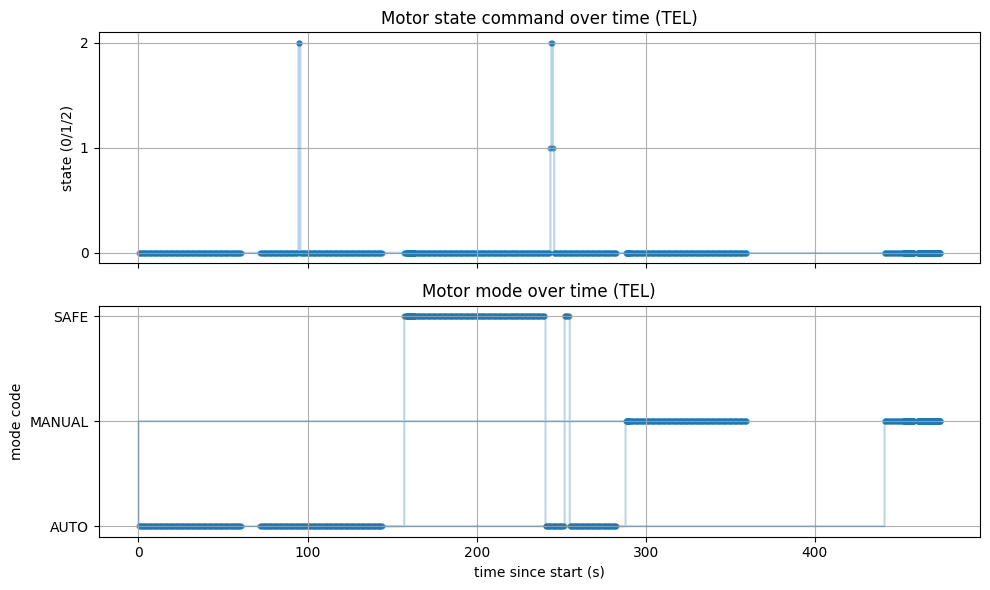

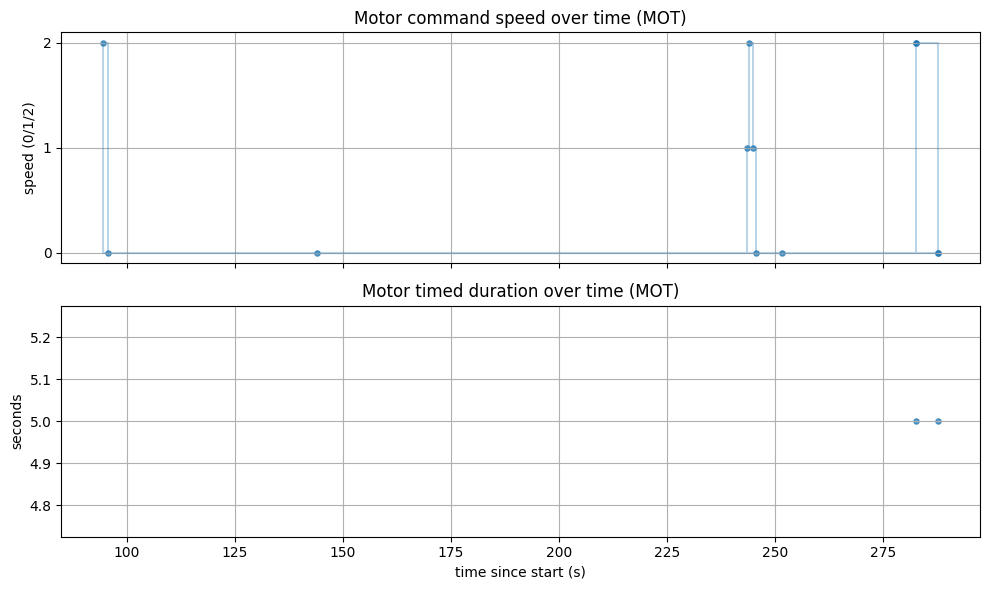

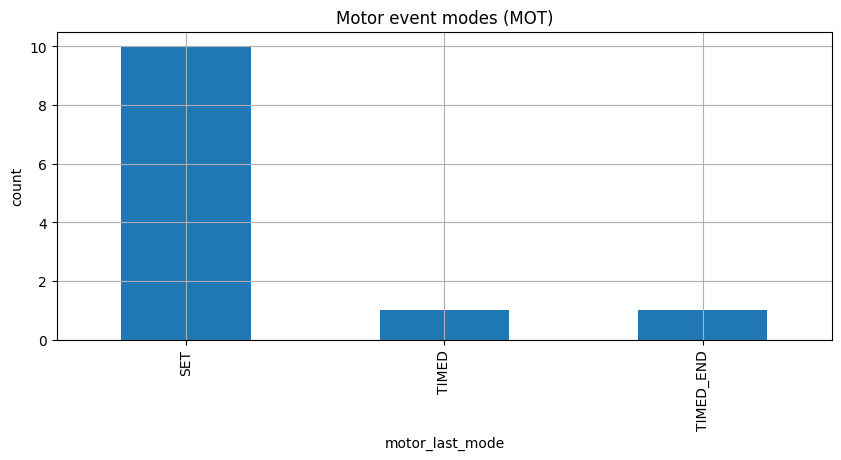

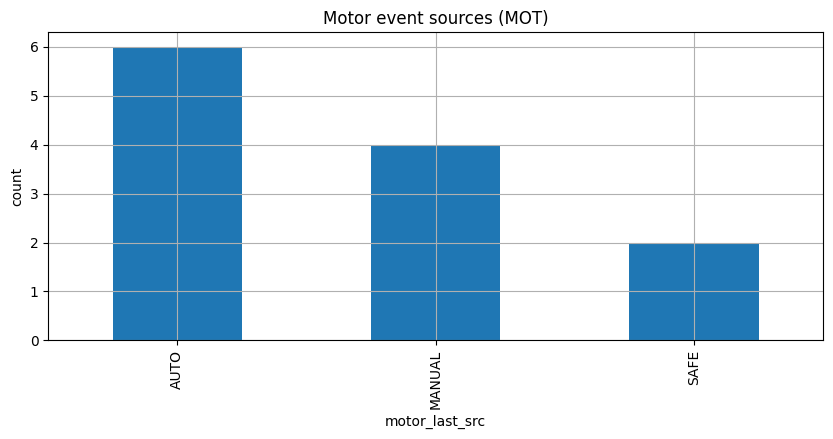

In [17]:
tel = event_df("TEL")
if tel.empty:
    print("No TEL rows found for motor state.")
else:
    valid_states = [0, 1, 2]
    tel_state = tel[tel["motor_state_cmd"].isin(valid_states)].copy()

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

    if tel_state.empty:
        axes[0].text(0.5, 0.5, "No valid motor_state_cmd values", transform=axes[0].transAxes,
                     ha="center", va="center")
    else:
        axes[0].scatter(tel_state["t_s"], tel_state["motor_state_cmd"], s=12, alpha=0.6)
        axes[0].step(tel_state["t_s"], tel_state["motor_state_cmd"], where="post", alpha=0.3)
        axes[0].set_yticks([0, 1, 2])
    axes[0].set_title("Motor state command over time (TEL)")
    axes[0].set_ylabel("state (0/1/2)")

    mode_map = {"AUTO": 0, "MANUAL": 1, "SAFE": 2}
    mode_code = tel["motor_mode"].map(mode_map)
    tel_mode = tel[mode_code.notna()].copy()

    if tel_mode.empty:
        axes[1].text(0.5, 0.5, "No valid motor_mode values", transform=axes[1].transAxes,
                     ha="center", va="center")
    else:
        axes[1].scatter(tel_mode["t_s"], mode_code.loc[tel_mode.index], s=12, alpha=0.6)
        axes[1].step(tel_mode["t_s"], mode_code.loc[tel_mode.index], where="post", alpha=0.3)
    axes[1].set_title("Motor mode over time (TEL)")
    axes[1].set_ylabel("mode code")
    axes[1].set_yticks([0, 1, 2])
    axes[1].set_yticklabels(["AUTO", "MANUAL", "SAFE"])
    axes[1].set_xlabel("time since start (s)")

    plt.tight_layout()
    plt.show()

mot = event_df("MOT")
if mot.empty:
    print("No MOT rows found.")
else:
    valid_states = [0, 1, 2]
    mot_speed = mot[mot["motor_last_speed"].isin(valid_states)].copy()

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

    if mot_speed.empty:
        axes[0].text(0.5, 0.5, "No valid motor_last_speed values", transform=axes[0].transAxes,
                     ha="center", va="center")
    else:
        axes[0].scatter(mot_speed["t_s"], mot_speed["motor_last_speed"], s=14, alpha=0.7)
        axes[0].step(mot_speed["t_s"], mot_speed["motor_last_speed"], where="post", alpha=0.3)
        axes[0].set_yticks([0, 1, 2])
    axes[0].set_title("Motor command speed over time (MOT)")
    axes[0].set_ylabel("speed (0/1/2)")

    axes[1].scatter(mot["t_s"], mot["motor_last_seconds"], s=14, alpha=0.7)
    axes[1].set_title("Motor timed duration over time (MOT)")
    axes[1].set_ylabel("seconds")
    axes[1].set_xlabel("time since start (s)")

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 4))
    mot["motor_last_mode"].value_counts().plot(kind="bar", ax=ax)
    ax.set_title("Motor event modes (MOT)")
    ax.set_xlabel("motor_last_mode")
    ax.set_ylabel("count")
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 4))
    mot["motor_last_src"].value_counts().plot(kind="bar", ax=ax)
    ax.set_title("Motor event sources (MOT)")
    ax.set_xlabel("motor_last_src")
    ax.set_ylabel("count")
    plt.show()



## Sun sensor
Raw readings, threshold comparison, detections, and value distribution.



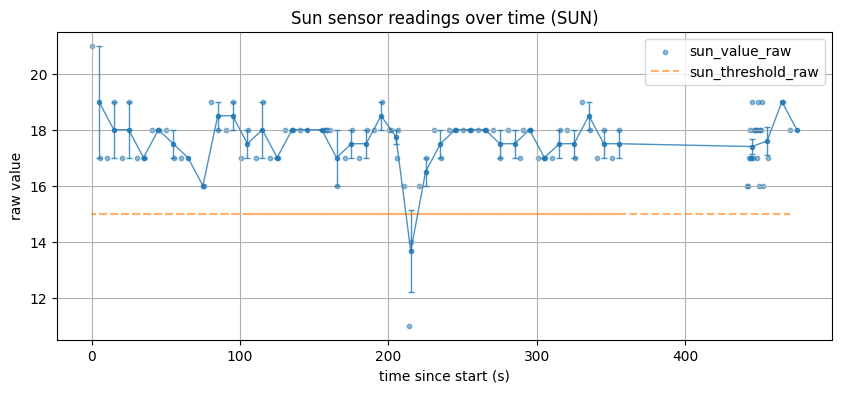

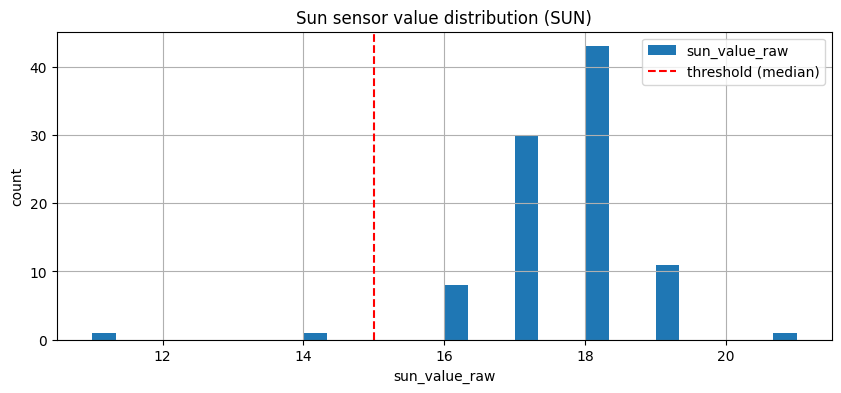

In [18]:
sun = event_df("SUN")
if sun.empty:
    print("No SUN rows found.")
else:
    bin_s = 10
    colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
    color0 = colors[0] if colors else None
    color1 = colors[1] if len(colors) > 1 else None

    fig, ax = plt.subplots(figsize=(10, 4))
    scatter_with_binned_mean(ax, sun["t_s"], sun["sun_value_raw"], bin_s, label="sun_value_raw", color=color0, alpha=0.5, s=10)
    if sun["sun_threshold_raw"].notna().any():
        ax.plot(sun["t_s"], sun["sun_threshold_raw"], color=color1, alpha=0.6, linestyle="--", label="sun_threshold_raw")
    ax.set_title("Sun sensor readings over time (SUN)")
    ax.set_xlabel("time since start (s)")
    ax.set_ylabel("raw value")
    ax.legend()
    plt.show()

    plt.figure(figsize=(10, 4))
    sun["sun_value_raw"].dropna().plot(kind="hist", bins=30)
    thr = sun["sun_threshold_raw"].dropna().median()
    if np.isfinite(thr):
        plt.axvline(thr, color="red", linestyle="--", label="threshold (median)")
        plt.legend()
    plt.title("Sun sensor value distribution (SUN)")
    plt.xlabel("sun_value_raw")
    plt.ylabel("count")
    plt.show()



## Camera brightest pixels
Time series of the top-3 brightest pixel values, spatial scatter, density heatmaps, and motion vectors.



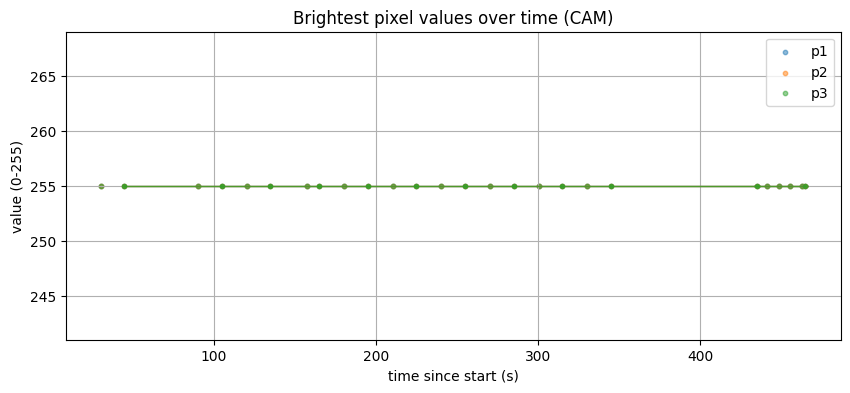

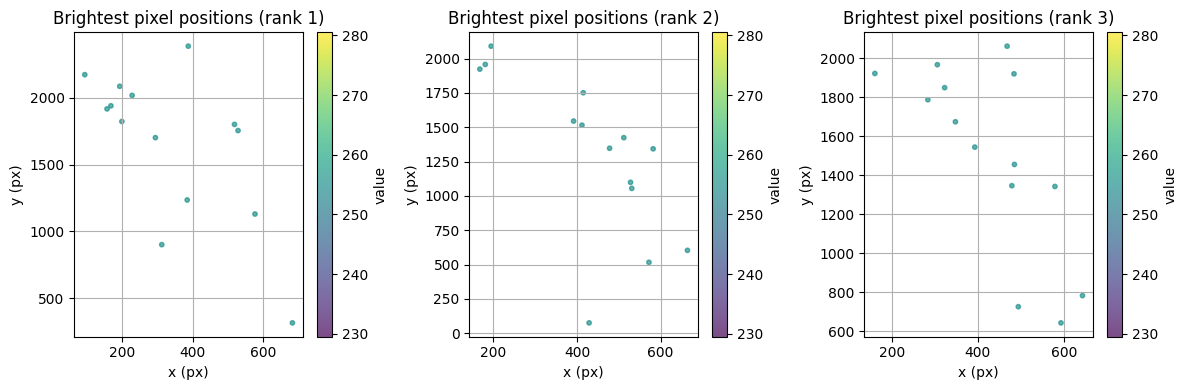

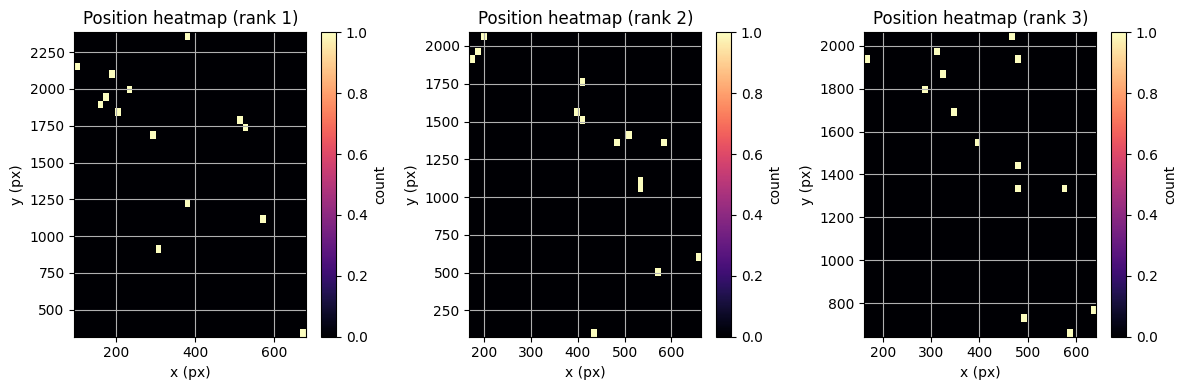

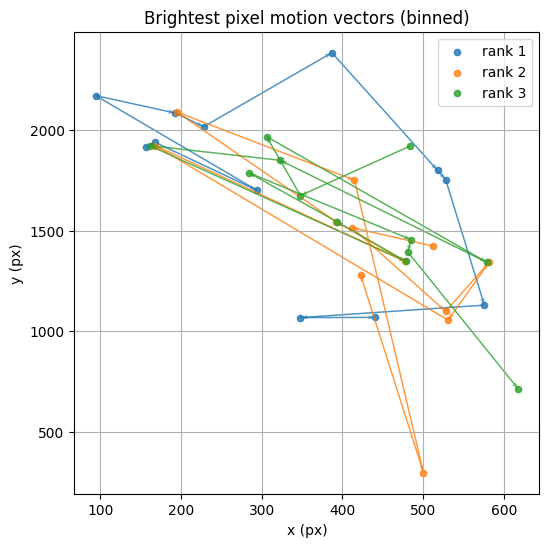

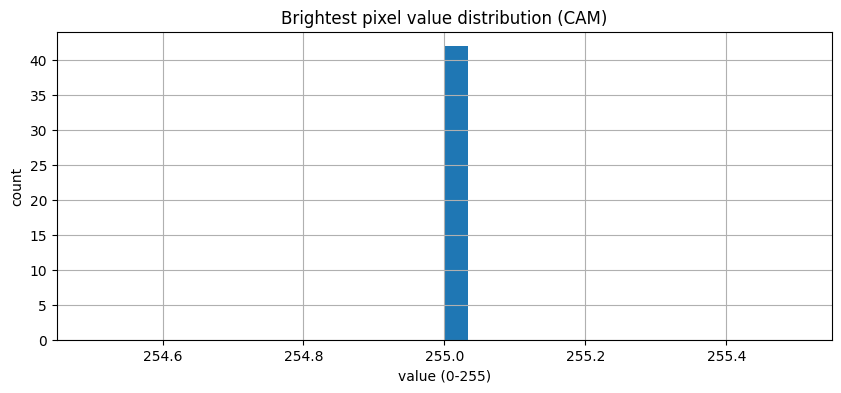

In [19]:
cam = event_df("CAM")
if cam.empty:
    print("No CAM rows found.")
else:
    bin_s = 30
    colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])

    fig, ax = plt.subplots(figsize=(10, 4))
    for i, r in enumerate([1, 2, 3]):
        color = colors[i % len(colors)] if colors else None
        scatter_with_binned_mean(ax, cam["t_s"], cam[f"cam_p{r}_value"], bin_s, label=f"p{r}", color=color, alpha=0.5, s=10)
    ax.set_title("Brightest pixel values over time (CAM)")
    ax.set_xlabel("time since start (s)")
    ax.set_ylabel("value (0-255)")
    ax.legend()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax, r in zip(axes, [1, 2, 3]):
        x = cam[f"cam_p{r}_x_px"]
        y = cam[f"cam_p{r}_y_px"]
        v = cam[f"cam_p{r}_value"]
        sc = ax.scatter(x, y, c=v, cmap="viridis", s=10, alpha=0.7)
        ax.set_title(f"Brightest pixel positions (rank {r})")
        ax.set_xlabel("x (px)")
        ax.set_ylabel("y (px)")
        fig.colorbar(sc, ax=ax, label="value")
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax, r in zip(axes, [1, 2, 3]):
        x = cam[f"cam_p{r}_x_px"]
        y = cam[f"cam_p{r}_y_px"]
        data = cam[[f"cam_p{r}_x_px", f"cam_p{r}_y_px"]].dropna()
        if data.empty:
            ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center", va="center")
        else:
            h = ax.hist2d(data[f"cam_p{r}_x_px"], data[f"cam_p{r}_y_px"], bins=40, cmap="magma")
            fig.colorbar(h[3], ax=ax, label="count")
        ax.set_title(f"Position heatmap (rank {r})")
        ax.set_xlabel("x (px)")
        ax.set_ylabel("y (px)")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(6, 6))
    for i, r in enumerate([1, 2, 3]):
        color = colors[i % len(colors)] if colors else None
        data = cam[["t_s", f"cam_p{r}_x_px", f"cam_p{r}_y_px"]].dropna()
        if data.empty:
            continue
        data = data.rename(columns={f"cam_p{r}_x_px": "x", f"cam_p{r}_y_px": "y"})
        data["bin"] = (data["t_s"] // bin_s).astype(int)
        mean_pos = data.groupby("bin")[["x", "y"]].mean().sort_index()
        if len(mean_pos) < 2:
            continue
        x = mean_pos["x"].to_numpy()
        y = mean_pos["y"].to_numpy()
        dx = np.diff(x)
        dy = np.diff(y)
        ax.scatter(x, y, s=20, alpha=0.8, color=color, label=f"rank {r}")
        ax.plot(x, y, color=color, alpha=0.3, linewidth=1)
        ax.quiver(x[:-1], y[:-1], dx, dy, angles="xy", scale_units="xy", scale=1,
                  color=color, alpha=0.7, width=0.003)
    ax.set_title("Brightest pixel motion vectors (binned)")
    ax.set_xlabel("x (px)")
    ax.set_ylabel("y (px)")
    ax.legend()
    plt.show()

    plt.figure(figsize=(10, 4))
    cam[["cam_p1_value", "cam_p2_value", "cam_p3_value"]].stack().plot(kind="hist", bins=30)
    plt.title("Brightest pixel value distribution (CAM)")
    plt.xlabel("value (0-255)")
    plt.ylabel("count")
    plt.show()



## Spectral summary table
A compact summary of spectral processing metrics and per-line statistics.



In [20]:
spec = event_df("SPEC")
if spec.empty:
    print("No SPEC rows found.")
else:
    def col_mean(name):
        return spec[name].mean() if name in spec.columns else np.nan

    def col_median(name):
        return spec[name].median() if name in spec.columns else np.nan

    def col_p95(name):
        return spec[name].quantile(0.95) if name in spec.columns else np.nan

    summary = {
        "total_rows": len(spec),
        "ok_rate": col_mean("spec_ok"),
        "line_count_mean": col_mean("spec_num_lines"),
        "line_count_median": col_median("spec_num_lines"),
        "noise_std_mean": col_mean("spec_noise_std_adu"),
        "runtime_ms_mean": col_mean("spec_runtime_ms"),
        "runtime_ms_p95": col_p95("spec_runtime_ms"),
        "wall_time_ms_mean": col_mean("spec_wall_time_s") * 1000.0,
        "packet_bytes_mean": col_mean("spec_packet_bytes"),
        "packet_bytes_sum": spec["spec_packet_bytes"].sum() if "spec_packet_bytes" in spec.columns else np.nan,
    }

    summary_df = pd.DataFrame({"value": summary}).rename_axis("metric")
    summary_df["value"] = summary_df["value"].astype(float).round(3)

    try:
        from IPython.display import display
        display(summary_df)
    except Exception:
        print(summary_df)

    line_rows = []
    for i in range(8):
        c = f"spec_line{i}_centroid_nm"
        f = f"spec_line{i}_fwhm_nm"
        s = f"spec_line{i}_snr"
        if c not in spec.columns:
            continue
        sub = spec[[c, f, s]].dropna(subset=[c])
        line_rows.append({
            "line_index": i,
            "detections": int(sub[c].count()),
            "centroid_nm_mean": sub[c].mean(),
            "centroid_nm_std": sub[c].std(),
            "fwhm_nm_mean": sub[f].mean(),
            "snr_mean": sub[s].mean(),
        })

    if line_rows:
        line_df = pd.DataFrame(line_rows)
        line_df = line_df.sort_values("line_index")
        line_df = line_df.round(3)
        try:
            from IPython.display import display
            display(line_df)
        except Exception:
            print(line_df)
    else:
        print("No spectral line columns found.")



,value
metric,
total_rows,1.000
ok_rate,1.000
line_count_mean,3.000
line_count_median,3.000
noise_std_mean,5617.194
runtime_ms_mean,39.099
runtime_ms_p95,39.099
wall_time_ms_mean,49.384
packet_bytes_mean,50.000


,line_index,detections,centroid_nm_mean,centroid_nm_std,fwhm_nm_mean,snr_mean
0,0,1,312.340,NaN,0.240,6.594
1,1,1,313.560,NaN,0.229,8.665
2,2,1,327.847,NaN,0.304,5.500
3,3,0,NaN,NaN,NaN,NaN
4,4,0,NaN,NaN,NaN,NaN
5,5,0,NaN,NaN,NaN,NaN
6,6,0,NaN,NaN,NaN,NaN
7,7,0,NaN,NaN,NaN,NaN
